In [309]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [310]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 20})

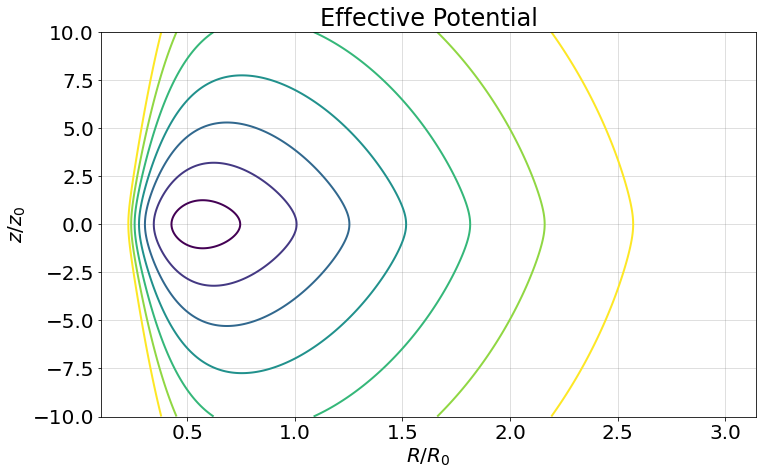

In [361]:
# Sizes of the plot
size_x = 11
size_y = 7

# Set the units in AGAMA (length, velocity, mass)
agama.setUnits(length=1, velocity=1, mass=1)

# Initialize AGAMA multi-component potential for the Milky Way
# Define the disk parameters separately
scaleradius = 3.0
scaleheight = 0.28
disk = dict(type='miyamotonagai', mass=6.8e10, scaleradius=scaleradius, scaleheight=scaleheight)
potential = agama.Potential(disk,  # disk
                                dict(type='dehnen', mass=5.00e9, scaleradius=1.0),   # bulge
                                dict(type='dehnen', mass=1.71e9, scaleradius=0.07),  # nucleus
                                dict(type='nfw', mass=5.4e11, scaleradius=15.62), # halo
                           )

# Define the specific angular momentum Lz (choose an appropriate value)
Lz = 300.0 

# Generate grid of R and z values (unscaled coordinates)
R_min, R_max, R_points = 0.1, 2*size_x/size_y, 1000   # R in units set (length unit)
z_min, z_max, z_points = -10, 10, 1000  # z in units set (length unit)

R = np.linspace(R_min, R_max, R_points) * scaleradius
z = np.linspace(z_min, z_max, z_points) * scaleheight
RR, ZZ = np.meshgrid(R, z)

# Flatten the grids for vectorized computation
R_flat = RR.flatten()
z_flat = ZZ.flatten()
x_flat = R_flat  # In cylindrical coordinates, x = R, y = 0 for the meridional plane
y_flat = np.zeros_like(R_flat)

# Compute the gravitational potential at each point
Phi_grav = potential.potential(np.column_stack((x_flat, y_flat, z_flat)))

# Compute the centrifugal potential term
epsilon = 1e-12  # Small value to avoid division by zero at R=0
R_safe = np.where(R_flat == 0, epsilon, R_flat)
Phi_cent = Lz**2 / (2 * R_safe**2)

# Total effective potential
Phi_eff = Phi_grav + Phi_cent

# Reshape the potential arrays back to the grid shape
Phi_eff_grid = Phi_eff.reshape(RR.shape)

# Determine the range of effective potential levels where closed contours exist
Phi_min = np.percentile(Phi_eff_grid, 1)
Phi_max = np.percentile(Phi_eff_grid, 70)
levels = np.linspace(Phi_min, Phi_max, 7)

# Compute scaled coordinates for plotting
R_scaled = RR / scaleradius
z_scaled = ZZ / scaleheight

# Setup plot
plt.figure(figsize=(size_x, size_y))

# Plotting the contours using scaled coordinates
contour = plt.contour(R_scaled, z_scaled, Phi_eff_grid, levels=levels, cmap='viridis', linewidths = 2)

plt.title('Effective Potential')
plt.xlabel('$R / R_0$')
plt.ylabel('$z / z_0$')

plt.grid(True)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.xlim(R_scaled.min(), R_scaled.max())
plt.ylim(z_scaled.min(), z_scaled.max())

plt.tight_layout()
plt.savefig("../Figures/axisymmetric_phieff.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

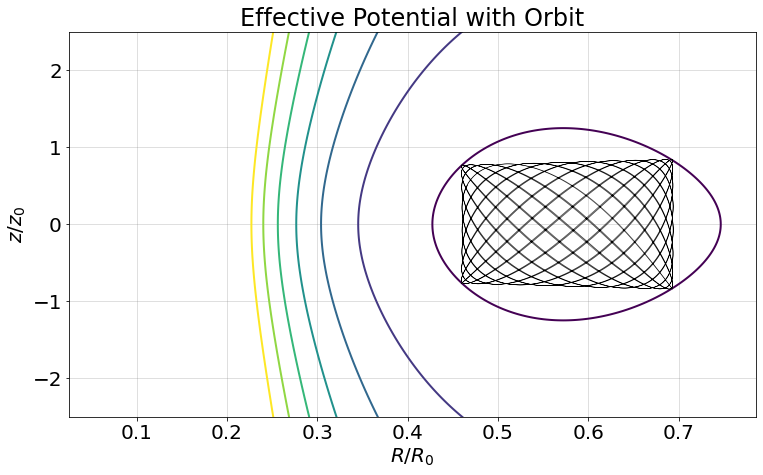

In [362]:
# Plot orbits for a given energy level
# ------------------------------------------
# Select energy level by picking an index in the array of levels
level_ind = 0

# Because many heights are possible select a height percentile
z_perc = 40

# ------------------------------------------

# Compute tolerance for Phi eff array
diff_row = np.diff(Phi_eff_grid, axis=0)  # Differences between rows
diff_col = np.diff(Phi_eff_grid, axis=1)  # Differences between columns

# Flatten the differences and compute the typical difference
all_diffs = np.concatenate((diff_row.flatten(), diff_col.flatten()))
tol = np.percentile(np.abs(all_diffs), 50)  # Use mean or median as needed

# Find the indices where Phi_eff_grid is approximately equal to X
approx_indices = np.argwhere(np.abs(Phi_eff_grid - levels[level_ind]) <= tol)

# Retrieve the corresponding R,z
# Choose z corresponding to a percentile in possible zs
R0s = RR[approx_indices[:, 0], approx_indices[:, 1]]
z0s = ZZ[approx_indices[:, 0], approx_indices[:, 1]]
z0_approx = np.percentile(np.abs(z0s), z_perc)
z_ind = np.abs(np.abs(z0s) - z0_approx).argmin()
z0 = z0s[z_ind]
R0 =  R0s[z_ind]

# Initial velocities
vR0 = 0.0
vz0 = 0.0
vphi0 = Lz / R0  # Ensure Lz = R0 * vphi0

# Initial conditions in Cartesian coordinates
x0 = R0
y0 = 0.0
z0 = z0
vx0 = vR0
vy0 = vphi0
vz0 = vz0

# Integrate the orbit
posvel = [x0, y0, z0, vx0, vy0, vz0]

period_circ = potential.Tcirc(posvel)

orbit = agama.orbit(
    potential=potential,
    ic=posvel,
    time=50*period_circ, trajsize=10000)

# Get the orbit trajectory
times = orbit[0]
coords = orbit[1]
x_orbit = coords[:, 0]
y_orbit = coords[:, 1]
z_orbit = coords[:, 2]
vx_orbit = coords[:, 3]
vy_orbit = coords[:, 4]
vz_orbit = coords[:, 5]

# Compute R for the orbit
R_orbit = np.sqrt(x_orbit**2 + y_orbit**2)

# Scale the coordinates for plotting
R_orbit_scaled = R_orbit / scaleradius
z_orbit_scaled = z_orbit / scaleheight

# Plotting the contours
plt.figure(figsize=(size_x, size_y))
contour = plt.contour(R_scaled, z_scaled, Phi_eff_grid, levels=levels, cmap='viridis', linewidths=2)
plt.title('Effective Potential with Orbit')
plt.xlabel('$R / R_0$')
plt.ylabel('$z / z_0$')
plt.grid(True)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)
zoom_scale = 0.25
plt.xlim(zoom_scale*R_scaled.min(), zoom_scale*R_scaled.max())
plt.ylim(zoom_scale*z_scaled.min(), zoom_scale*z_scaled.max())

# Plot the orbit on top of the contours
# Plot only the first N% of points in the orbit
num_points = len(R_orbit_scaled)
first_n_percent = int(0.3 * num_points)
plt.plot(R_orbit_scaled[:first_n_percent], z_orbit_scaled[:first_n_percent], color='black', linewidth=0.4)

plt.tight_layout()
plt.savefig("../Figures/axisymmetric_phieff_orbit_z"+str(z_perc)+".png", format="png",
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


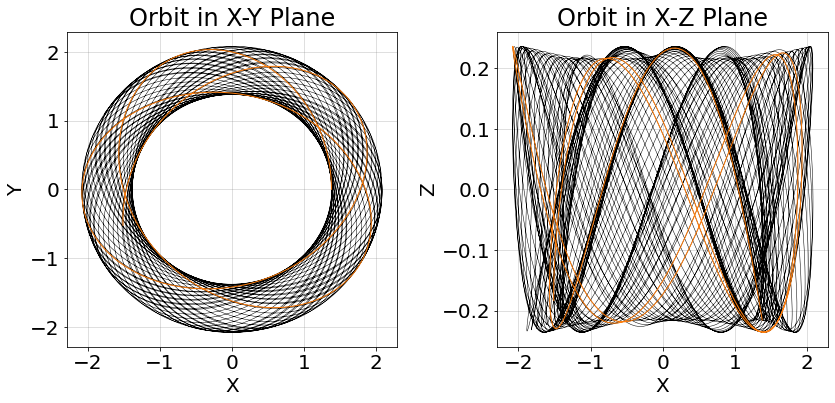

In [363]:
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the orbit in the X,Y plane (black color)
ax1.plot(x_orbit, y_orbit, color='black', linewidth=0.5)
first_n_percent = int(0.05 * num_points)
ax1.plot(x_orbit[:first_n_percent], y_orbit[:first_n_percent], color='tab:orange', linewidth=1)

ax1.set_title("Orbit in X-Y Plane")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Plot the orbit in the X,Z plane (black color)
ax2.plot(x_orbit, z_orbit, color='black', linewidth=0.5)
ax2.plot(x_orbit[:first_n_percent], z_orbit[:first_n_percent], color='tab:orange', linewidth=1)
ax2.set_title("Orbit in X-Z Plane")
ax2.set_xlabel("X")
ax2.set_ylabel("Z")
ax2.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Adjust layout to ensure titles and labels are well-spaced
plt.tight_layout()

plt.savefig("../Figures/axisymmetric_phieff_orbit_z"+str(z_perc)+"_xy_xz_projection.png", format="png",
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

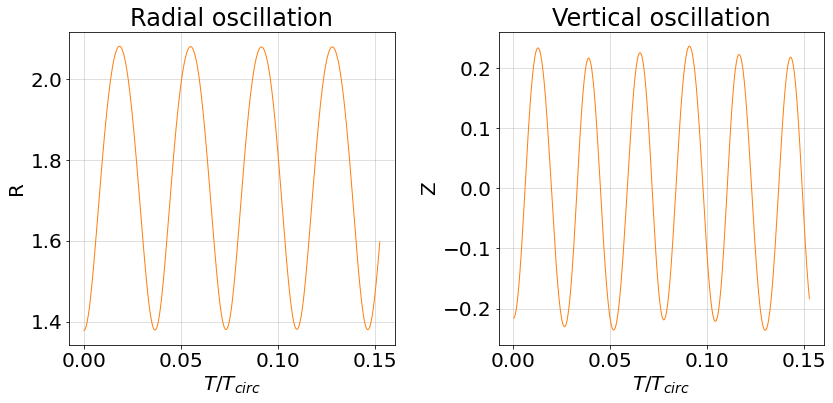

In [364]:
# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the orbit in the X,Y plane (black color)
R2 = np.sqrt(x_orbit**2+y_orbit**2)
ax1.plot(times[:first_n_percent], R2[:first_n_percent], color='tab:orange', linewidth=1)

ax1.set_title("Radial oscillation")
ax1.set_xlabel("$T/T_{circ}$")
ax1.set_ylabel("R")
ax1.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Plot the orbit in the X,Z plane (black color)
ax2.plot(times[:first_n_percent], z_orbit[:first_n_percent], color='tab:orange', linewidth=1)
ax2.set_title("Vertical oscillation")
ax2.set_xlabel("$T/T_{circ}$")
ax2.set_ylabel("Z")
ax2.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Adjust layout to ensure titles and labels are well-spaced
plt.tight_layout()

plt.savefig("../Figures/axisymmetric_phieff_orbit_z"+str(z_perc)+"_rt_zt_oscillation.png", format="png",
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


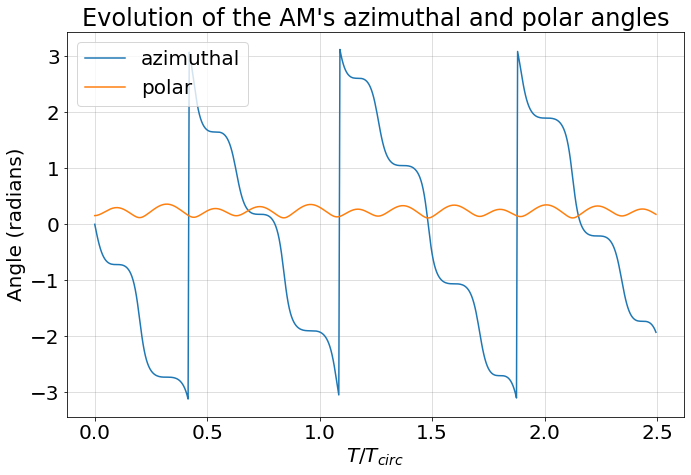

In [365]:
# Compute the angular momentum vector components (Lx, Ly, Lz) at each time step
Lx = y_orbit * vz_orbit - z_orbit * vy_orbit
Ly = z_orbit * vx_orbit - x_orbit * vz_orbit
Lz = x_orbit * vy_orbit - y_orbit * vx_orbit

# Normalize the angular momentum vector at each time step
L_magnitude = np.sqrt(Lx**2 + Ly**2 + Lz**2)
Lx_unit = Lx / L_magnitude
Ly_unit = Ly / L_magnitude
Lz_unit = Lz / L_magnitude

# Convert to spherical polar angles phi and theta
phi = np.arctan2(Ly_unit, Lx_unit)  # Azimuthal angle
theta = np.arccos(Lz_unit)          # Polar angle

# Set up the figure with a single subplot
plt.figure(figsize=(10, 7))

# Plot the evolution of phi and theta over time
plt.plot(times[:first_n_percent]/period_circ, phi[:first_n_percent], color='tab:blue', linewidth=1.5, 
         label='azimuthal')
plt.plot(times[:first_n_percent]/period_circ, theta[:first_n_percent], color='tab:orange', linewidth=1.5, 
         label='polar')
plt.xlabel("$T/T_{circ}$")
plt.ylabel("Angle (radians)")
plt.title("Evolution of the AM's azimuthal and polar angles")

plt.legend()

plt.grid(True)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Adjust layout and display
plt.tight_layout()

plt.savefig("../Figures/axisymmetric_phieff_orbit_z"+str(z_perc)+"_am_angles.png", format="png",
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


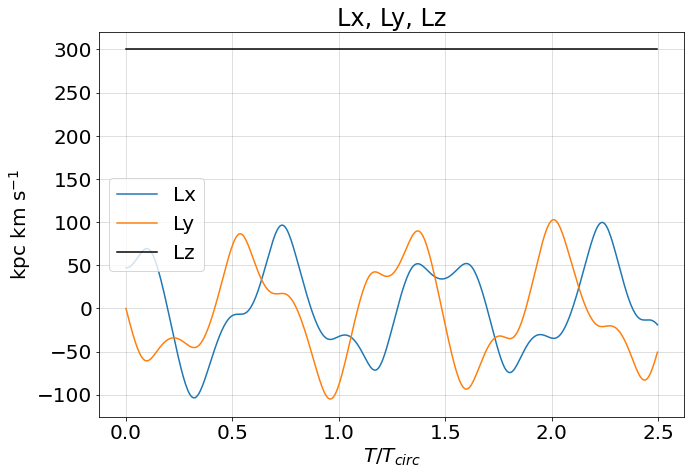

In [366]:
# Set up the figure with a single subplot
plt.figure(figsize=(10, 7))

# Plot the evolution of phi and theta over time
plt.plot(times[:first_n_percent]/period_circ, Lx[:first_n_percent], color='tab:blue', linewidth=1.5, 
         label='Lx')
plt.plot(times[:first_n_percent]/period_circ, Ly[:first_n_percent], color='tab:orange', linewidth=1.5, 
         label='Ly')
plt.plot(times[:first_n_percent]/period_circ, Lz[:first_n_percent], color='black', linewidth=1.5, 
         label='Lz')

plt.xlabel("$T/T_{circ}$")
plt.ylabel("kpc km s$^{-1}$")
plt.title("Lx, Ly, Lz")

plt.legend()

plt.grid(True)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Adjust layout and display
plt.tight_layout()

plt.savefig("../Figures/axisymmetric_phieff_orbit_z"+str(z_perc)+"_am_components.png", format="png",
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()